# Essential dynamics

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from itertools import combinations

import numpy as np
import seaborn as sns

from typing import Iterable
from sklearn.decomposition import PCA

sns.set_style("white")

plt.rcParams["figure.dpi"] = 300

In [2]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
models = torch.load(f"../model1.pt", map_location=DEVICE)


In [3]:
def plot_explained_variance(pca, title="Explained Variance", ax: plt.Axes = None):
    num_pca_components = pca.n_components
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(
        range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components]
    )
    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha="center", va="bottom")
    ax.set_title(title)
    ax.set_xlabel("PC")
    ax.set_ylabel("Explained Variance")

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))

In [4]:
def get_output_for_model(model: nn.Module, dataloader: DataLoader):
    model.to(DEVICE)
    logits = []
    with torch.no_grad():
        for xs, ys in dataloader:
            xs, ys = xs.to(model.device), ys.to(model.device)
            outputs = model(xs, ys)
            logits.append(outputs)
    logits = torch.cat(logits).to("cpu")
    return logits


def get_output_for_models(models: Iterable[nn.Module], dataloader: DataLoader):
    outputs = torch.stack([get_output_for_model(model, dataloader) for model in models])
    return outputs.reshape(len(outputs), -1)


def get_pca_components(samples, n_components):
    pca = PCA(n_components=n_components)
    transformed_samples = pca.fit_transform(samples)
    return pca, transformed_samples


def get_form_figure(pca, transformed_samples, figsize=(20, 4)):
    num_pca_components = pca.n_components
    pca_combos = list(combinations(range(num_pca_components), 2))
    num_pca_combos = len(pca_combos)
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=figsize)
    for ax_idx, (first_pca_index, second_pca_index) in enumerate(pca_combos):
        sns.scatterplot(
            x=transformed_samples[:, first_pca_index],
            y=transformed_samples[:, second_pca_index],
            ax=axes[ax_idx],
            alpha=0.5,
            color="gray",
            s=10,
            legend=False,
        )
        axes[ax_idx].plot(
            transformed_samples[:, first_pca_index],
            transformed_samples[:, second_pca_index],
        )
        axes[ax_idx].set_xlabel(f"PC {first_pca_index+1}")
        axes[ax_idx].set_ylabel(f"PC {second_pca_index+1}")
        axes[ax_idx].set_title(f"PC {second_pca_index+1} vs PC {first_pca_index+1}")
    plot_explained_variance(pca, ax=axes[-1])
    plt.tight_layout(rect=[0, 0, 1, 1])
    return fig

In [5]:
BATCH_SIZE = 1024
dataset = torch.load("ED_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
outputs = get_output_for_models(models, dataloader)

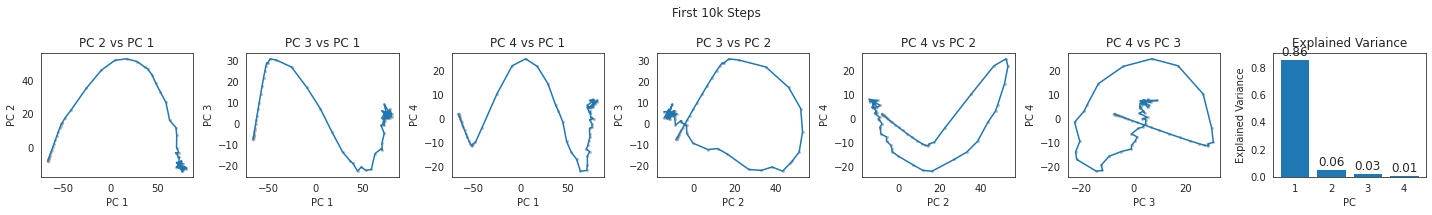

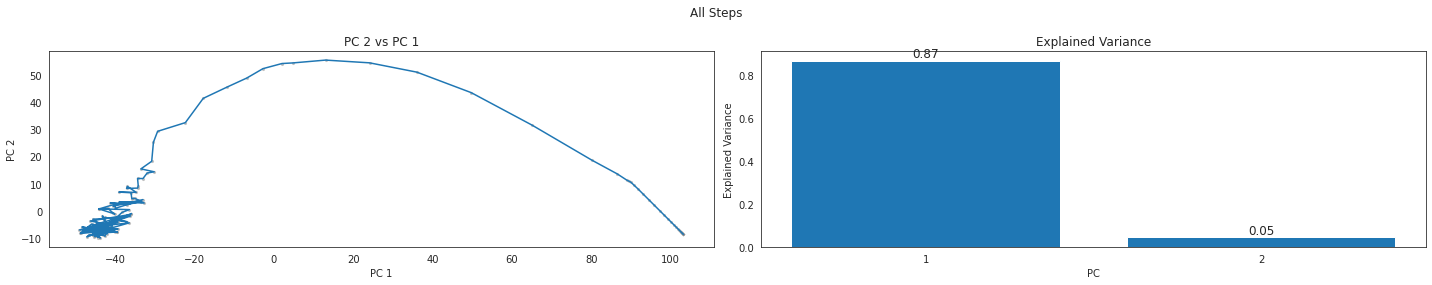

In [6]:
_all_outputs = outputs

pca, transformed_samples = get_pca_components(_all_outputs[:101], n_components=4)
fig = get_form_figure(pca, transformed_samples, figsize=(20, 3))
fig.suptitle("First 10k Steps")
plt.tight_layout()
plt.show()

pca, transformed_samples = get_pca_components(_all_outputs, n_components=2)
fig = get_form_figure(pca, transformed_samples, figsize=(20, 4))
fig.suptitle("All Steps")
plt.tight_layout()
plt.show()